# Required Libs

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
import contractions  
import nltk
from nltk.util import pr
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from gensim.models import Word2Vec
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords   
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Data acquisition

In [2]:
df = pd.read_csv("hate_speech_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [4]:
df_text_label = df[['class', 'tweet']]

In [5]:
df_text_label.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Labeling class

In [6]:
df_text_label["labels"] = df_text_label["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive"})
df_text_label.head()

,class,tweet,labels
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [7]:
df_text_label['labels'].value_counts()

Offensive Language       19190
No Hate and Offensive     4163
Hate Speech               1430
Name: labels, dtype: int64

# EDA

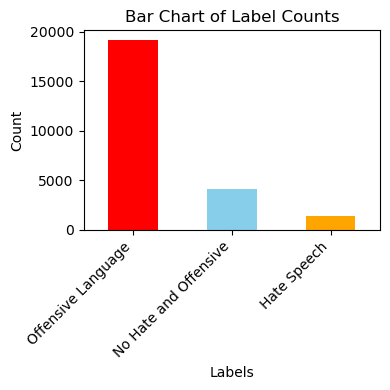

In [8]:
label_counts = df_text_label['labels'].value_counts()
plt.figure(figsize=(4, 4))
label_counts.plot(kind='bar', color=['red','skyblue', "orange"])
plt.title('Bar Chart of Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better readability
plt.tight_layout()
plt.show()

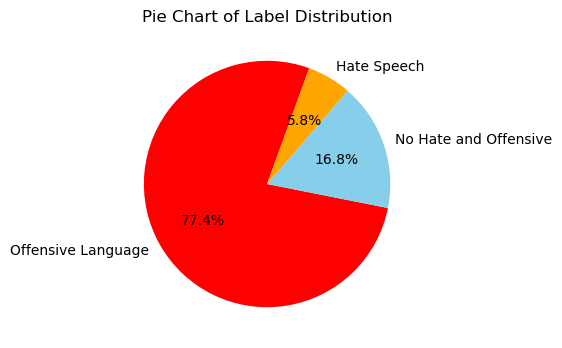

In [9]:
# Pie Chart
plt.figure(figsize=(4, 4))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=70, colors=['red','skyblue', "orange"])
plt.title('Pie Chart of Label Distribution')
plt.ylabel('')  # Remove the default 'count' label on the y-axis
plt.show()

Oversampling using random imputation from the existing categories

In [10]:
max_count = max(df_text_label['labels'].value_counts())
oversampled_df = pd.DataFrame(columns=df_text_label.columns)
for label in df_text_label['labels'].unique():
    subset = df_text_label[df_text_label['labels'] == label]
    replicated_subset = pd.concat([subset] * (max_count // len(subset)), ignore_index=True)
    additional_samples_needed = max_count - len(replicated_subset)
    if additional_samples_needed > 0:
        replicated_subset = pd.concat([replicated_subset, subset.sample(additional_samples_needed, replace=True)], ignore_index=True)
    oversampled_df = pd.concat([oversampled_df, replicated_subset], ignore_index=True)
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

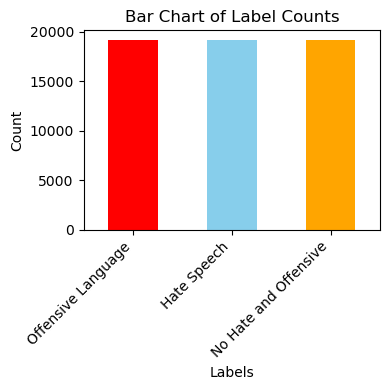

In [11]:
label_counts =oversampled_df['labels'].value_counts()
plt.figure(figsize=(4, 4))
label_counts.plot(kind='bar', color=['red','skyblue', "orange"])
plt.title('Bar Chart of Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [12]:
train_data= df[["tweet", "class"]]
train_data['tweet'] = train_data['tweet'].str.replace(r'@\S+', '', regex=True)

In [13]:
train_data.head()

,tweet,class
0,!!! RT As a woman you shouldn't complain abou...,2
1,!!!!! RT boy dats cold...tyga dwn bad for cuf...,1
2,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...,1
3,!!!!!!!!! RT she look like a tranny,1
4,!!!!!!!!!!!!! RT The shit you hear about me m...,1


In [14]:
oversampled_df.shape

(57570, 3)

# Text Processing 

In [15]:
def expand_contractions(text):
    return contractions.fix(text) 
def clean(text):
    ### stext to lower-case 
    text = str(text).lower()
    ### handling special characters and  punctuations
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    ### Expanding contractions uisng functin above 
    text = expand_contractions(text)
    tweet_tokens = word_tokenize(text)
    # removing stopwords and words with length <= 2
    filtered_tweets = [w for w in tweet_tokens if not (len(w) <= 2 or w in stopword)]  
    return " ".join(filtered_tweets)


In [16]:
stopword = set(stopwords.words('english'))
train_data.tweet=train_data['tweet'].apply(clean)

# Cleaned data

In [17]:
train_data.head()

,tweet,class
0,woman complain cleaning house amp man always t...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch start cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told,1


In [18]:
train_data.shape

(24783, 2)

In [19]:
## dictionary for handing slangs and short owrds in the text 

In [20]:
slangs=   { "lol": "laugh out loud",
    "brb": "be right back",
    "omg": "oh my god",
    "btw": "by the way",
    "fyi": "for your information",
    "idk": "I don't know",
    "imo": "in my opinion",
    "smh": "shake my head",
    "tbh": "to be honest",
    "yolo": "you only live once",
    "bff": "best friends forever",
    "gr8": "great",
    "gonna": "going to",
    "wanna": "want to",
    "gimme": "give me",
    "gonna": "going to",
    "haha": "laugh",
    "tmi": "too much information",
    "thx": "thanks",
    "cya": "see you later",
    "imo": "in my opinion",
    "irl": "in real life",
    "fomo": "fear of missing out",
    "btw": "by the way",
    "rofl": "rolling on the floor laughing",
    "omw": "on my way",
    "fyi": "for your information",
    "nsfw": "not safe for work",
    "smh": "shake my head",
    "imo": "in my opinion",
    "lit": "excellent or awesome",
    "fwiw": "for what it's worth",
    "gtg": "got to go",
    "nvm": "never mind",
    "otp": "on the phone",
    "oml": "oh my Lord",
    "atm": "at the moment",
    "afk": "away from keyboard",
    "icymi": "in case you missed it",
    "srsly": "seriously",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "hbu": "how about you",
    "smexy": "sexy and smart",
    "afaik": "as far as I know",
    "b4": "before",
    "cu": "see you",
    "da": "the",
    "gonna": "going to",
    "gratz": "congratulations",
    "h8": "hate",
    "jk": "just kidding",
    "kk": "okay",
    "lmao": "laughing my ass off",
    "lmk": "let me know",
    "np": "no problem",
    "obv": "obviously",
    "ppl": "people",
    "rly": "really",
    "srs": "serious",
    "tho": "though",
    "u": "you",
    "ur": "your",
    "wut": "what",
    "y": "why",
    "2moro": "tomorrow",
    "bday": "birthday",
    "cuz": "because",
    "fam": "family",
    "gf": "girlfriend",
    "hmu": "hit me up",
    "ily": "I love you",
    "jk": "just kidding",
    "l8r": "later",
    "m8": "mate",
    "nbd": "no big deal",
    "omg": "oh my god",
    "plz": "please",
    "qt": "cutie",
    "r": "are",
    "sry": "sorry",
    "thx": "thanks",
    "vibe": "atmosphere",
    "yolo": "you only live once",
    "zomg": "oh my god (sarcastic)",
    "lit": "awesome",
    "finna": "fixing to",
    "pov": "point of view",
    "smol": "small",
    "yass": "yes",
    "ftw": "for the win",
    "glhf": "good luck, have fun",
    "bae": "before anyone else",
    "savage": "fierce or ruthless",
    "dope": "excellent",
    "GOAT": "greatest of all time",
    "meme": "internet humor",
    "ship": "relationship",
    "vibing": "enjoying the mood",
    "flex": "showing off",
    "ghost": "suddenly end communication",
    "snack": "attractive person",
    "woke": "socially aware",
    "yeet": "express excitement or approval",
    "clout": "influence or prestige",
    "lit AF": "extremely awesome",
    "extra": "excessive or over the top",
    "fleek": "perfect or flawless",
    "OG": "original gangster",
    "sus": "suspicious or shady",
    "TFW": "that feeling when",
    "YOLO": "you only live once", "imo": "in my opinion",
    "hmu": "hit me up",
    "btw": "by the way",
    "irl": "in real life",
    "fomo": "fear of missing out",
    "rofl": "rolling on the floor laughing",
    "omw": "on my way",
    "nsfw": "not safe for work",
    "srsly": "seriously",
    "imho": "in my humble opinion",
    "tmi": "too much information",
    "fwiw": "for what it's worth",
    "gtg": "got to go",
    "nvm": "never mind",
    "otp": "on the phone",
    "oml": "oh my Lord",
    "atm": "at the moment",
    "afk": "away from keyboard",
    "icymi": "in case you missed it",
    "srsly": "seriously",
    "hbu": "how about you",
    "smexy": "sexy and smart",
    "afaik": "as far as I know",
    "b4": "before",
    "cu": "see you",
    "da": "the",
    "gratz": "congratulations",
    "h8": "hate",
    "jk": "just kidding",
    "kk": "okay",
    "lmao": "laughing my ass off",
    "lmk": "let me know",
    "np": "no problem",
    "obv": "obviously",
    "ppl": "people",
    "rly": "really",
    "srs": "serious",
    "tho": "though",
    "u": "you",
    "ur": "your",
    "wut": "what",
    "y": "why",
    "2moro": "tomorrow",
    "bday": "birthday",
    "cuz": "because",
    "fam": "family",
    "gf": "girlfriend",
    "ily": "I love you",
    "l8r": "later",
    "m8": "mate",
    "nbd": "no big deal",
    "plz": "please",
    "qt": "cutie",
    "r": "are",
    "sry": "sorry",
    "thx": "thanks",
    "vibe": "atmosphere",
    "yolo": "you only live once",
    "zomg": "oh my god (sarcastic)",
    "lit": "awesome",
    "finna": "fixing to",
    "pov": "point of view",
    "smol": "small",
    "yass": "yes",
    "ftw": "for the win",
    "glhf": "good luck, have fun",
    "bae": "before anyone else",
    "savage": "fierce or ruthless",
    "dope": "excellent",
    "goat": "greatest of all time",
    "meme": "internet humor",
    "ship": "relationship",
    "vibing": "enjoying the mood",
    "flex": "showing off",
    "ghost": "suddenly end communication",
    "snack": "attractive person",
    "woke": "socially aware",
    "yeet": "express excitement or approval",
    "clout": "influence or prestige",
    "lit AF": "extremely awesome",
    "extra": "excessive or over the top",
    "fleek": "perfect or flawless",
}


In [21]:
def slang_handler(text):
    words = text.split()
    expanded_words = [slangs.get(word, word) for word in words]
    return ' '.join(expanded_words)

# Apply the function to the 'tweet' column
train_data['tweet'] = train_data['tweet'].apply(slang_handler)

In [22]:
train_data.head()

,tweet,class
0,woman complain cleaning house amp man always t...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch start cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told,1


# Class words analysis 

No hate tweets

In [23]:
non_hate_tweets = train_data[train_data['class'] == 2]
non_hate_tweets.head()

,tweet,class
0,woman complain cleaning house amp man always t...,2
40,momma said pussy cats inside doghouse,2
63,simplyaddictedtoguys woof woof hot scally lad,2
66,woof woof hot soles,2
67,lemmie eat oreo amp dishes one oreo laugh out ...,2


# Significant words in no hate speech 

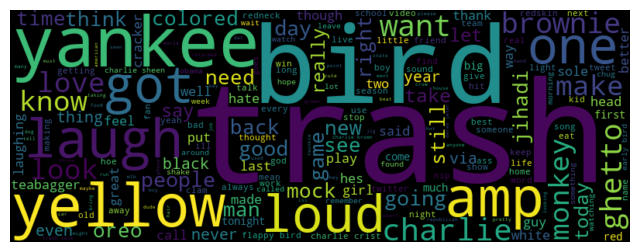

In [24]:
text = ' '.join(non_hate_tweets['tweet'])
wordcloud = WordCloud(width=800, height=300, background_color='black').generate(text)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Offensive Language

# Significant words in Offensive Language

In [25]:
Offensive_Language_tweets = train_data[train_data['class'] == 1]
Offensive_Language_tweets.head()

,tweet,class
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch start cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told,1
5,shit blows meclaim faithful somebody still fuc...,1


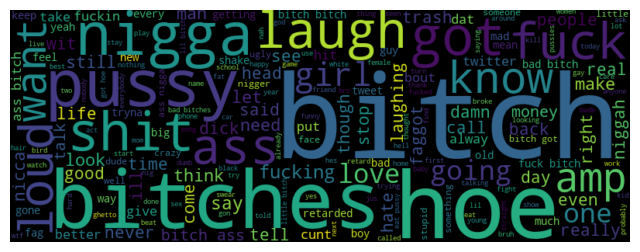

In [26]:
text = ' '.join(Offensive_Language_tweets['tweet'])
wordcloud = WordCloud(width=800, height=300, background_color='black').generate(text)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Hate Speech

# Significant words in Hate Speech

In [27]:
Hate_Speech_tweets = train_data[train_data['class'] == 0]
Hate_Speech_tweets.head()

,tweet,class
85,queer gaywad,0
89,alsarabsss hes beaner shake my head tell hes m...,0
110,fucking gay blacklisted hoe holding tehgodclan...,0
184,lmfaoooo hate black people black people niggers,0
202,least nigger lmfao,0


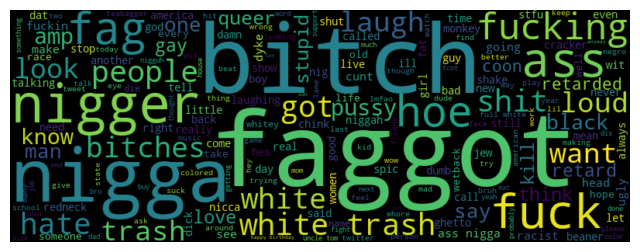

In [28]:
text = ' '.join(Hate_Speech_tweets['tweet'])
wordcloud = WordCloud(width=800, height=300, background_color='black').generate(text)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Train /Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'], train_data['class'], test_size=0.2, random_state=42)

# Models Traditional  ===>  Machine Learning Models

Multinomial Support Vector Machine (SVM) model with Word2Vec word embeddings

In [30]:
###Word2vec model configuration
modelword2vec = Word2Vec(X_train, vector_size=400, window=10, min_count=1, sg=0)

In [31]:
### Helper function to Calculate the average Word2Vec vector for each tweet
def get_average_word_vector(tweet, model, vector_size):
    words = tweet.split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if not word_vectors:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

In [32]:
# Label Encoding for multiclass classification
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [33]:
X_train_embeddings = np.array([get_average_word_vector(tweet, modelword2vec, 400) for tweet in X_train])
X_test_embeddings = np.array([get_average_word_vector(tweet, modelword2vec, 400) for tweet in X_test])
# Training the Multinomial SVM model
svm_classifier = SVC(kernel='linear', C=1, decision_function_shape='ovr')
svm_classifier.fit(X_train_embeddings, y_train_encoded)

# Evaluate the model
accuracy = svm_classifier.score(X_test_embeddings, y_test_encoded)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7730482146459552


In [34]:
# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test_embeddings)
print(y_pred)

[1 1 1 ... 1 1 1]


In [35]:
print(len(y_pred))

4957


In [36]:
print(len(y_test))

4957


In [37]:
class_mapping = {
    0: "Hate Speech",
    1: "Offensive Language",
    2: "No Hate and Offensive"
}

Precision: 0.5976035421672988
Recall: 0.7730482146459552
F1 Score: 0.6740973395206054


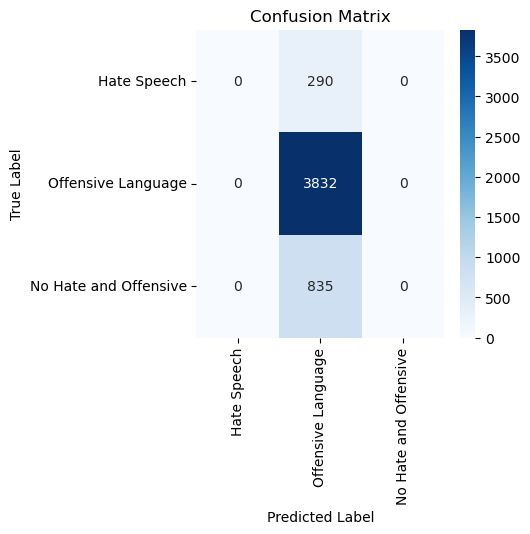

In [38]:
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

precision = precision_score(y_test,  y_pred, average='weighted')
recall = recall_score(y_test,  y_pred, average='weighted')
f1 = f1_score(y_test,  y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
conf_matrix = confusion_matrix(y_test,  y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.values(),
            yticklabels=class_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# MultinomialNB with Count Vectorization

In [39]:
### Text count Vectorization
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

Precision: 0.8516014294372968
Recall: 0.864635868468832
F1 Score: 0.8367370494594621
Accuracy: 0.864635868468832


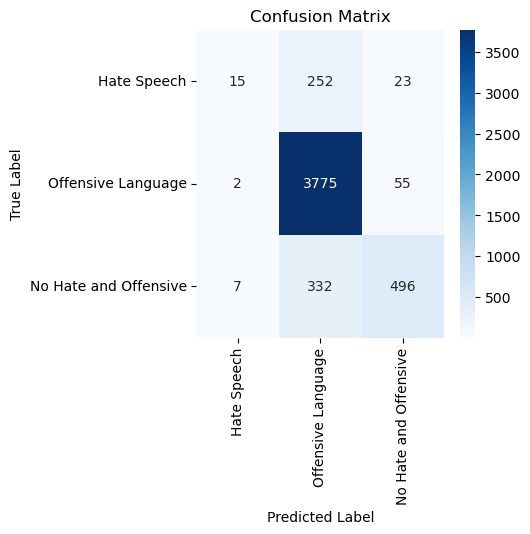

In [40]:
# Train the Multinomial Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)
y_pred = nb_classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.values(),
            yticklabels=class_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Training the XGBoost model
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_vectorized, y_train)
# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8896509985878556


Precision: 0.8824865805211828
Recall: 0.8896509985878556
F1 Score: 0.879559225177775


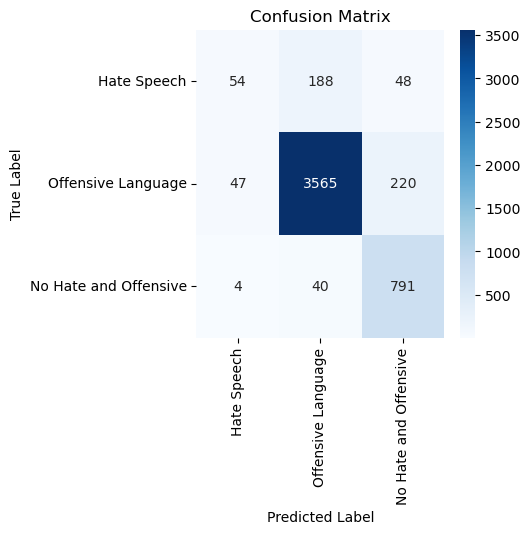

In [42]:
y_pred = xgb_classifier.predict(X_test_vectorized)  # X_test is your test data
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.values(),
            yticklabels=class_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:


#### Defining the parameter grid for hyperparameter-tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
}

#### Initializing the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()
###### Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)
#### Printing out the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
y_pred_tuned = grid_search.best_estimator_.predict(X_test_vectorized)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned Model Accuracy: {accuracy_tuned}")

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'subsample': 1.0}
Tuned Model Accuracy: 0.8906596731894291


Precision: 0.8823563897939095
Recall: 0.8906596731894291
F1 Score: 0.8798745191685832


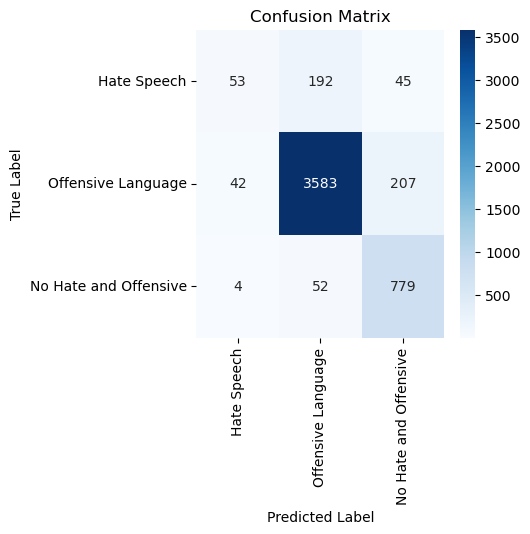

In [45]:

precision = precision_score(y_test, y_pred_tuned, average='weighted')
recall = recall_score(y_test, y_pred_tuned, average='weighted')
f1 = f1_score(y_test, y_pred_tuned, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.values(),
            yticklabels=class_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=100) 
X_test_padded = pad_sequences(X_test_sequences, maxlen=100)
# Build the GRU model
GRU_model = keras.Sequential([
    keras.layers.Embedding(10000, 32, input_length=100),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.GRU(64),
    keras.layers.Dense(3, activation='softmax')  # 3 classes (0, 1, 2)
])

GRU_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training up the model
GRU_model.fit(X_train_padded, y_train, epochs=10, batch_size=32)
loss, accuracy = GRU_model.evaluate(X_test_padded, y_test)
print(f"Test accuracy: {accuracy}")


Epoch 1/10
620/620 [==============================] - 66s 98ms/step - loss: 0.3993 - accuracy: 0.8614
Epoch 2/10
620/620 [==============================] - 67s 107ms/step - loss: 0.2296 - accuracy: 0.9194
Epoch 3/10
620/620 [==============================] - 72s 116ms/step - loss: 0.1640 - accuracy: 0.9432
Epoch 4/10
620/620 [==============================] - 61s 98ms/step - loss: 0.1254 - accuracy: 0.9568
Epoch 5/10
620/620 [==============================] - 62s 100ms/step - loss: 0.1017 - accuracy: 0.9647
Epoch 6/10
620/620 [==============================] - 60s 97ms/step - loss: 0.0859 - accuracy: 0.9692
Epoch 7/10
620/620 [==============================] - 69s 112ms/step - loss: 0.0725 - accuracy: 0.9752
Epoch 8/10
620/620 [==============================] - 64s 104ms/step - loss: 0.0624 - accuracy: 0.9787
Epoch 9/10
620/620 [==============================] - 78s 126ms/step - loss: 0.0539 - accuracy: 0.9811
Epoch 10/10
155/155 [==============================] - 5s 25ms/step - loss: 

In [44]:
y_pred = GRU_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)
print("Predicted class labels for test data:")
print(y_pred_labels)

155/155 [==============================] - 5s 28ms/step
Predicted class labels for test data:
[1 1 1 ... 1 1 1]


y_test shape: (4957,)
Precision: 0.8500161265439196
Recall: 0.851523098648376
F1 Score: 0.8504316023301909


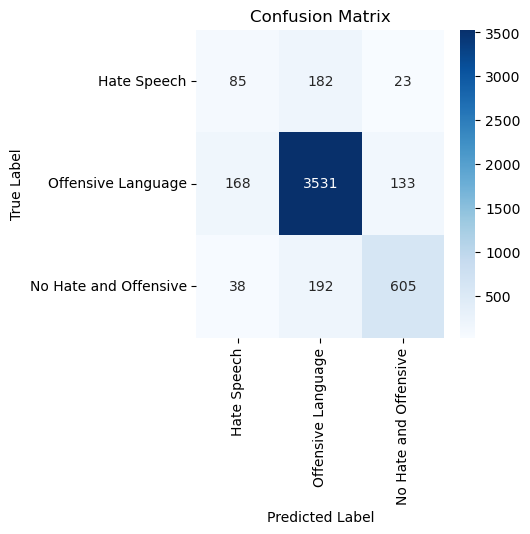

In [45]:
# Check the structure of y_test
print("y_test shape:", y_test.shape)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test,y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
conf_matrix = confusion_matrix(y_test, y_pred_labels)
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.values(),
            yticklabels=class_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [46]:
##### Building the LSTM model
LSTM_model = Sequential([
    Embedding(10000, 32, input_length=100),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(3, activation='softmax') 
])

LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LSTM_model.fit(X_train_padded, y_train, epochs=10, batch_size=32)
# Evaluate the model
loss, accuracy = LSTM_model.evaluate(X_test_padded, y_test)
print(f"Test accuracy: {accuracy}")


Epoch 1/10
620/620 [==============================] - 73s 108ms/step - loss: 0.4170 - accuracy: 0.8566
Epoch 2/10
620/620 [==============================] - 81s 131ms/step - loss: 0.2575 - accuracy: 0.9137
Epoch 3/10
620/620 [==============================] - 70s 113ms/step - loss: 0.1876 - accuracy: 0.9337
Epoch 4/10
620/620 [==============================] - 69s 112ms/step - loss: 0.1395 - accuracy: 0.9516
Epoch 5/10
620/620 [==============================] - 71s 115ms/step - loss: 0.1115 - accuracy: 0.9619
Epoch 6/10
620/620 [==============================] - 72s 116ms/step - loss: 0.0931 - accuracy: 0.9667
Epoch 7/10
620/620 [==============================] - 87s 141ms/step - loss: 0.0808 - accuracy: 0.9714
Epoch 8/10
620/620 [==============================] - 68s 110ms/step - loss: 0.0712 - accuracy: 0.9747
Epoch 9/10
620/620 [==============================] - 70s 112ms/step - loss: 0.0654 - accuracy: 0.9763
Epoch 10/10
155/155 [==============================] - 12s 59ms/step - lo

In [47]:
y_pred = LSTM_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)
print("Predicted class labels for test data:")
print(y_pred_labels)

155/155 [==============================] - 9s 46ms/step
Predicted class labels for test data:
[1 1 1 ... 1 1 1]


In [48]:
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.8540689393974082
Recall: 0.8587855557797055
F1 Score: 0.8560768511724791


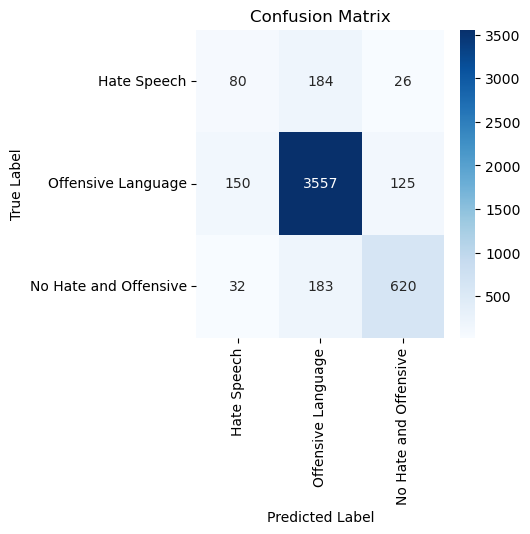

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.values(),
            yticklabels=class_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Comparison Analysis Part

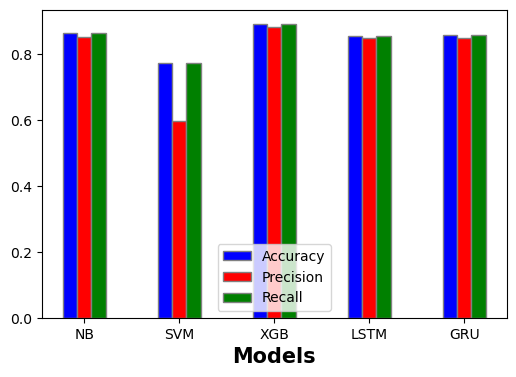

In [50]:

model_performance = {
    'NB': {'Accuracy': 0.8646, 'Precision': 0.8516, 'Recall': 0.8646},
    'SVM': {'Accuracy': 0.7730, 'Precision': 0.5976, 'Recall': 0.7730},
    'XGB': {'Accuracy': 0.8897, 'Precision': 0.8825, 'Recall': 0.8897},
    'LSTM': {'Accuracy': 0.8550, 'Precision': 0.8492, 'Recall': 0.8550},
    'GRU': {'Accuracy': 0.8574, 'Precision': 0.8492, 'Recall': 0.8574}
}
barWidth = 0.15

# Set position of bar on X axis
r1 = np.arange(len(model_performance))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.figure(figsize=(6,4))
#### Creating bars for accuracy
plt.bar(r1, [model_performance[model]['Accuracy'] for model in model_performance], color='blue', width=barWidth, edgecolor='grey', label='Accuracy')
#### Creating bars for precision
plt.bar(r2, [model_performance[model]['Precision'] for model in model_performance], color='red', width=barWidth, edgecolor='grey', label='Precision')
### Creating bars for recall
plt.bar(r3, [model_performance[model]['Recall'] for model in model_performance], color='green', width=barWidth, edgecolor='grey', label='Recall')

# Adding labels
plt.xlabel('Models', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(model_performance))], list(model_performance.keys()))

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [51]:
Biasness table analysis 

SyntaxError: invalid syntax (3030474817.py, line 1)

In [ ]:
# Confusion matrices for each model
confusion_matrices = {
    'NB': np.array([[83, 188, 25], [47, 3569, 117], [4, 40, 604]]),
    'SVM': np.array([[0, 290, 0], [0, 3832, 0], [0, 835, 0]]),
    'XGB': np.array([[77, 186, 25], [143, 3565, 117], [33, 219, 583]]),
    'LSTM': np.array([[54, 135, 48], [143, 3572, 128], [43, 188, 496]]),
    'GRU': np.array([[83, 182, 48], [135, 3569, 220], [33, 219, 791]])
}
### Initializing a dictionary to hold the biasness scores for each model
biasness_scores = {model: {} for model in confusion_matrices}
for model, matrix in confusion_matrices.items():
    # Sum the misclassifications (off-diagonal elements) for each class
    misclassifications = matrix.sum(axis=1) - np.diag(matrix)
    # Sum the total instances (all elements) for each class
    total_instances = matrix.sum(axis=1)
    # Calculate the biasness score for each class
    biasness_scores[model]['Class 0'] = misclassifications[0] / total_instances[0]
    biasness_scores[model]['Class 1'] = misclassifications[1] / total_instances[1]
    biasness_scores[model]['Class 2'] = misclassifications[2] / total_instances[2]
    # Calculate the average biasness score across all classes
    biasness_scores[model]['Average'] = misclassifications.mean() / total_instances.mean()

# Create a table with the biasness scores
biasness_table = [["Model", "Class 0 Biasness", "Class 1 Biasness", "Class 2 Biasness", "Average Biasness"]]
for model, scores in biasness_scores.items():
    row = [model]
    row.extend(scores.values())
    biasness_table.append(row)
biasness_table